In [1]:
import pandas as pd
import numpy as np
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.extract as extract

## This Notebook Will be for Predicting ANC Churn on fullset of bikes, will then attempt to apply models to ebikes as well

In [2]:
# List of filenames
a, b, c = extract.build_paths(csv_url='csv')

csv_paths = extract.compile_paths(a,b,c)

raw_dfs = extract.import_csvs(csv_paths)



## The Columns Are Not All The Same

- Observe recent difference in col naming convention for the set

In [5]:
col_names = [df.columns for df in raw_dfs]
col_names

[Index(['Duration', 'Start date', 'End date', 'Start station number',
        'Start station', 'End station number', 'End station', 'Bike number',
        'Member type'],
       dtype='object'),
 Index(['Duration', 'Start date', 'End date', 'Start station number',
        'Start station', 'End station number', 'End station', 'Bike number',
        'Member type'],
       dtype='object'),
 Index(['Duration', 'Start date', 'End date', 'Start station number',
        'Start station', 'End station number', 'End station', 'Bike number',
        'Member type'],
       dtype='object'),
 Index(['Duration', 'Start date', 'End date', 'Start station number',
        'Start station', 'End station number', 'End station', 'Bike number',
        'Member type'],
       dtype='object'),
 Index(['Duration', 'Start date', 'End date', 'Start station number',
        'Start station', 'End station number', 'End station', 'Bike number',
        'Member type'],
       dtype='object'),
 Index(['Duration', 'Star

## But the Information Is Roughly The Same
- Notably different items are:
    - Rideable Type (All of the old sets are presumed to be Docked Bikes)
    - Missing Lat/Lng (need an imputation strategy)
    - Different Station ID/Numbering Convention (not a huge deal)
    - No Unique Ride ID (we'll want to add this if using this Data)

In [6]:
raw_dfs[0]

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,552,2018-01-01 00:05:06,2018-01-01 00:14:18,31104,Adams Mill & Columbia Rd NW,31400,Georgia & New Hampshire Ave NW,W00886,Member
1,1282,2018-01-01 00:14:30,2018-01-01 00:35:53,31321,15th St & Constitution Ave NW,31321,15th St & Constitution Ave NW,W01435,Casual
2,1265,2018-01-01 00:14:53,2018-01-01 00:35:58,31321,15th St & Constitution Ave NW,31321,15th St & Constitution Ave NW,W21242,Casual
3,578,2018-01-01 00:15:31,2018-01-01 00:25:09,31406,14th & Upshur St NW,31103,16th & Harvard St NW,W21322,Casual
4,372,2018-01-01 00:18:02,2018-01-01 00:24:15,31618,4th & East Capitol St NE,31619,Lincoln Park / 13th & East Capitol St NE,W00119,Member
...,...,...,...,...,...,...,...,...,...
168585,1377,2018-01-31 23:50:17,2018-02-01 00:13:14,31200,Massachusetts Ave & Dupont Circle NW,31265,5th St & Massachusetts Ave NW,W21414,Casual
168586,761,2018-01-31 23:52:43,2018-02-01 00:05:24,31603,1st & M St NE,31628,1st & K St SE,W23213,Member
168587,738,2018-01-31 23:54:27,2018-02-01 00:06:45,31107,Lamont & Mt Pleasant NW,31114,18th St & Wyoming Ave NW,W21373,Member
168588,247,2018-01-31 23:56:31,2018-02-01 00:00:38,31623,Columbus Circle / Union Station,31612,D St & Maryland Ave NE,W20936,Member


## For Now, Let's Just Use the Recent Data

In [8]:
april_to_july_list = raw_dfs[-4:]
april_to_july_list[1] = april_to_july_list[1].drop('is_equity', axis=1)

raw_apr_to_jul_df = pd.concat(april_to_july_list)
raw_apr_to_jul_df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,495C10604A58ACA9,docked_bike,2020-04-27 10:33:08,2020-04-27 10:53:26,4th & M St SW,21.0,New York Ave & 15th St NW,124.0,38.876700,-77.017800,38.899000,-77.033400,member
1,08A5138C88D182A5,docked_bike,2020-04-27 11:20:07,2020-04-27 11:42:55,17th & K St NW,100.0,4th & M St SW,21.0,38.902800,-77.038600,38.876700,-77.017800,member
2,505E308BDCA9C792,docked_bike,2020-04-27 09:45:45,2020-04-27 09:54:32,1st & M St SE,578.0,4th & M St SW,21.0,38.876900,-77.006100,38.876700,-77.017800,member
3,D3436FC6CCF04110,docked_bike,2020-04-14 13:16:54,2020-04-14 13:28:59,11th & Kenyon St NW,15.0,Thomas Circle,178.0,38.929500,-77.027800,38.905900,-77.032500,casual
4,37B8457C89257BD5,docked_bike,2020-04-19 20:42:25,2020-04-19 20:51:12,13th & H St NE,97.0,Eastern Market / 7th & North Carolina Ave SE,96.0,38.900400,-76.988300,38.887000,-76.996800,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
228297,CD03F80ACB9AF2F4,docked_bike,2020-07-31 15:15:45,2020-07-31 16:25:22,5th & Kennedy St NW,86.0,Mount Vernon Ave & Four Mile Run Park,455.0,38.956555,-77.019814,38.843422,-77.064016,member
228298,A0060CB4B9B17F32,docked_bike,2020-07-20 19:35:00,2020-07-20 19:56:18,TJ Cmty Ctr / 2nd St & S Old Glebe Rd,361.0,N Lynn St & Fairfax Dr,491.0,38.869418,-77.095596,38.893860,-77.070862,casual
228299,E7BC1FE6BF9571F4,docked_bike,2020-07-01 16:56:24,2020-07-01 19:44:04,22nd & P ST NW,437.0,Adams Mill & Columbia Rd NW,17.0,38.909394,-77.048728,38.922925,-77.042581,casual
228300,B73B5EB431B2BA1E,docked_bike,2020-07-29 21:00:38,2020-07-29 21:35:10,Maine Ave & 7th St SW,95.0,Maine Ave & 7th St SW,95.0,38.878693,-77.023054,38.878694,-77.023054,casual


### About 35s to run clean_frame or to_geo on 100000 rows

In [9]:
%%time
cleaned_recent = clean.clean_frame(raw_apr_to_jul_df)
cleaned_recent

CPU times: user 4min 2s, sys: 1.44 s, total: 4min 4s
Wall time: 4min 4s


,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,start_coord,end_coord,ANC_start,ANC_end,duration_seconds
0,495C10604A58ACA9,docked_bike,2020-04-27 10:33:08,2020-04-27 10:53:26,4th & M St SW,New York Ave & 15th St NW,member,POINT (-77.01780 38.87670),POINT (-77.03340 38.89900),6D,2C,1218.0
1,08A5138C88D182A5,docked_bike,2020-04-27 11:20:07,2020-04-27 11:42:55,17th & K St NW,4th & M St SW,member,POINT (-77.03860 38.90280),POINT (-77.01780 38.87670),2B,6D,1368.0
2,505E308BDCA9C792,docked_bike,2020-04-27 09:45:45,2020-04-27 09:54:32,1st & M St SE,4th & M St SW,member,POINT (-77.00610 38.87690),POINT (-77.01780 38.87670),6D,6D,527.0
3,D3436FC6CCF04110,docked_bike,2020-04-14 13:16:54,2020-04-14 13:28:59,11th & Kenyon St NW,Thomas Circle,casual,POINT (-77.02780 38.92950),POINT (-77.03250 38.90590),1A,2F,725.0
4,37B8457C89257BD5,docked_bike,2020-04-19 20:42:25,2020-04-19 20:51:12,13th & H St NE,Eastern Market / 7th & North Carolina Ave SE,member,POINT (-76.98830 38.90040),POINT (-76.99680 38.88700),6A,6B,527.0
...,...,...,...,...,...,...,...,...,...,...,...,...
663425,CD03F80ACB9AF2F4,docked_bike,2020-07-31 15:15:45,2020-07-31 16:25:22,5th & Kennedy St NW,Mount Vernon Ave & Four Mile Run Park,member,POINT (-77.01981 38.95656),POINT (-77.06402 38.84342),4D,Outside,4177.0
663426,A0060CB4B9B17F32,docked_bike,2020-07-20 19:35:00,2020-07-20 19:56:18,TJ Cmty Ctr / 2nd St & S Old Glebe Rd,N Lynn St & Fairfax Dr,casual,POINT (-77.09560 38.86942),POINT (-77.07086 38.89386),Outside,Outside,1278.0
663427,E7BC1FE6BF9571F4,docked_bike,2020-07-01 16:56:24,2020-07-01 19:44:04,22nd & P ST NW,Adams Mill & Columbia Rd NW,casual,POINT (-77.04873 38.90939),POINT (-77.04258 38.92292),2B,1C,10060.0
663428,B73B5EB431B2BA1E,docked_bike,2020-07-29 21:00:38,2020-07-29 21:35:10,Maine Ave & 7th St SW,Maine Ave & 7th St SW,casual,POINT (-77.02305 38.87869),POINT (-77.02305 38.87869),6D,6D,2072.0


In [ ]:
full_import = test_read_starts.rename(columns={'started_at':'time-start', 'ended_at':'time-end',
                                               'ANC_start':'ANC-start', 'ANC_end':'ANC-end',
                                               'geom_start':'coord-start', 'geom_end':'coord-end',
                                               'start_station_name':'station_name-start', 'end_station_name':'station_name-end'
                                              })

In [12]:
# Creating SQLAlchemy's engine to use




geodataframe = cleaned_recent.copy()
#... [do something with the geodataframe]

geodataframe['geom_start'] = geodataframe['start_coord'].apply(lambda x: WKTElement(x.wkt, srid=4326))
geodataframe['geom_end'] = geodataframe['end_coord'].apply(lambda x: WKTElement(x.wkt, srid=4326))

                                                               
#drop the geometry column as it is now duplicative
geodataframe.drop(['start_coord','end_coord'], axis=1, inplace=True)

# Use 'dtype' to specify column's type
# For the geom column, we will use GeoAlchemy's type 'Geometry'
geodataframe.to_sql('trips', engine, if_exists='append', index=False, 
                         dtype={'geom_start': Geometry(geometry_type='POINT', srid=4326),
                               'geom_end': Geometry(geometry_type='POINT', srid=4326)})

# IT WORKS!

In [4]:
%%time
engine = pass
test_read_starts = gpd.read_postgis('trips', engine, geom_col='geom_start')
test_read_starts

CPU times: user 24 s, sys: 594 ms, total: 24.6 s
Wall time: 25 s


,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,ANC_start,ANC_end,duration_seconds,geom_start,geom_end
0,495C10604A58ACA9,docked_bike,2020-04-27 10:33:08,2020-04-27 10:53:26,4th & M St SW,New York Ave & 15th St NW,member,6D,2C,1218.0,POINT (-77.01780 38.87670),0101000020E6100000EEEBC039234253C0508D976E1273...
1,08A5138C88D182A5,docked_bike,2020-04-27 11:20:07,2020-04-27 11:42:55,17th & K St NW,4th & M St SW,member,2B,6D,1368.0,POINT (-77.03860 38.90280),0101000020E61000009A779CA2234153C09C33A2B43770...
2,505E308BDCA9C792,docked_bike,2020-04-27 09:45:45,2020-04-27 09:54:32,1st & M St SE,4th & M St SW,member,6D,6D,527.0,POINT (-77.00610 38.87690),0101000020E61000009A779CA2234153C09C33A2B43770...
3,D3436FC6CCF04110,docked_bike,2020-04-14 13:16:54,2020-04-14 13:28:59,11th & Kenyon St NW,Thomas Circle,casual,1A,2F,725.0,POINT (-77.02780 38.92950),0101000020E6100000AE47E17A144253C024B9FC87F473...
4,37B8457C89257BD5,docked_bike,2020-04-19 20:42:25,2020-04-19 20:51:12,13th & H St NE,Eastern Market / 7th & North Carolina Ave SE,member,6A,6B,527.0,POINT (-76.98830 38.90040),0101000020E6100000C7293A92CB3F53C0A8C64B378971...
...,...,...,...,...,...,...,...,...,...,...,...,...
659772,CD03F80ACB9AF2F4,docked_bike,2020-07-31 15:15:45,2020-07-31 16:25:22,5th & Kennedy St NW,Mount Vernon Ave & Four Mile Run Park,member,4D,Outside,4177.0,POINT (-77.01981 38.95656),0101000020E6100000EE9A90D6184453C00B5D8940F56B...
659773,A0060CB4B9B17F32,docked_bike,2020-07-20 19:35:00,2020-07-20 19:56:18,TJ Cmty Ctr / 2nd St & S Old Glebe Rd,N Lynn St & Fairfax Dr,casual,Outside,Outside,1278.0,POINT (-77.09560 38.86942),0101000020E6100000DE21C500894453C0ED9925016A72...
659774,E7BC1FE6BF9571F4,docked_bike,2020-07-01 16:56:24,2020-07-01 19:44:04,22nd & P ST NW,Adams Mill & Columbia Rd NW,casual,2B,1C,10060.0,POINT (-77.04873 38.90939),0101000020E6100000969BA8A5B94253C095D409682276...
659775,B73B5EB431B2BA1E,docked_bike,2020-07-29 21:00:38,2020-07-29 21:35:10,Maine Ave & 7th St SW,Maine Ave & 7th St SW,casual,6D,6D,2072.0,POINT (-77.02305 38.87869),0101000020E6100000FFFFFFB8794153C0A74E28087970...


In [3]:
test_read_ends = gpd.read_postgis('trips', engine, geom_col='geom_end')
test_read_ends

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,ANC_start,ANC_end,duration_seconds,geom_start,geom_end
0,495C10604A58ACA9,docked_bike,2020-04-27 10:33:08,2020-04-27 10:53:26,4th & M St SW,New York Ave & 15th St NW,member,6D,2C,1218.0,0101000020E61000009A779CA2234153C09C33A2B43770...,POINT (-77.03340 38.89900)
1,08A5138C88D182A5,docked_bike,2020-04-27 11:20:07,2020-04-27 11:42:55,17th & K St NW,4th & M St SW,member,2B,6D,1368.0,0101000020E61000000A68226C784253C0166A4DF38E73...,POINT (-77.01780 38.87670)
2,505E308BDCA9C792,docked_bike,2020-04-27 09:45:45,2020-04-27 09:54:32,1st & M St SE,4th & M St SW,member,6D,6D,527.0,0101000020E61000005C2041F1634053C063EE5A423E70...,POINT (-77.01780 38.87670)
3,D3436FC6CCF04110,docked_bike,2020-04-14 13:16:54,2020-04-14 13:28:59,11th & Kenyon St NW,Thomas Circle,casual,1A,2F,725.0,0101000020E61000000BB5A679C74153C0E5D022DBF976...,POINT (-77.03250 38.90590)
4,37B8457C89257BD5,docked_bike,2020-04-19 20:42:25,2020-04-19 20:51:12,13th & H St NE,Eastern Market / 7th & North Carolina Ave SE,member,6A,6B,527.0,0101000020E6100000C1A8A44E403F53C0C1A8A44E4073...,POINT (-76.99680 38.88700)
...,...,...,...,...,...,...,...,...,...,...,...,...
659772,CD03F80ACB9AF2F4,docked_bike,2020-07-31 15:15:45,2020-07-31 16:25:22,5th & Kennedy St NW,Mount Vernon Ave & Four Mile Run Park,member,4D,Outside,4177.0,0101000020E61000003080F0A1444153C0A3E9EC64707A...,POINT (-77.06402 38.84342)
659773,A0060CB4B9B17F32,docked_bike,2020-07-20 19:35:00,2020-07-20 19:56:18,TJ Cmty Ctr / 2nd St & S Old Glebe Rd,N Lynn St & Fairfax Dr,casual,Outside,Outside,1278.0,0101000020E61000003868AF3E1E4653C0E146CA16496F...,POINT (-77.07086 38.89386)
659774,E7BC1FE6BF9571F4,docked_bike,2020-07-01 16:56:24,2020-07-01 19:44:04,22nd & P ST NW,Adams Mill & Columbia Rd NW,casual,2B,1C,10060.0,0101000020E610000091990B5C1E4353C0DD96C8056774...,POINT (-77.04258 38.92292)
659775,B73B5EB431B2BA1E,docked_bike,2020-07-29 21:00:38,2020-07-29 21:35:10,Maine Ave & 7th St SW,Maine Ave & 7th St SW,casual,6D,6D,2072.0,0101000020E6100000B0027CB7794153C0B01C21037970...,POINT (-77.02305 38.87869)


## ...Sort of.
- One can write as many geometries as one likes, but I can't see how to read more then one geom_col
- Convert to Long Format (start/end col as one column of points, and one indicator of start/end), write that way

In [7]:
test_read_starts['geom_end'] = test_read_ends['geom_end']
test_read_starts

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,ANC_start,ANC_end,duration_seconds,geom_start,geom_end
0,495C10604A58ACA9,docked_bike,2020-04-27 10:33:08,2020-04-27 10:53:26,4th & M St SW,New York Ave & 15th St NW,member,6D,2C,1218.0,POINT (-77.01780 38.87670),POINT (-77.03340 38.89900)
1,08A5138C88D182A5,docked_bike,2020-04-27 11:20:07,2020-04-27 11:42:55,17th & K St NW,4th & M St SW,member,2B,6D,1368.0,POINT (-77.03860 38.90280),POINT (-77.01780 38.87670)
2,505E308BDCA9C792,docked_bike,2020-04-27 09:45:45,2020-04-27 09:54:32,1st & M St SE,4th & M St SW,member,6D,6D,527.0,POINT (-77.00610 38.87690),POINT (-77.01780 38.87670)
3,D3436FC6CCF04110,docked_bike,2020-04-14 13:16:54,2020-04-14 13:28:59,11th & Kenyon St NW,Thomas Circle,casual,1A,2F,725.0,POINT (-77.02780 38.92950),POINT (-77.03250 38.90590)
4,37B8457C89257BD5,docked_bike,2020-04-19 20:42:25,2020-04-19 20:51:12,13th & H St NE,Eastern Market / 7th & North Carolina Ave SE,member,6A,6B,527.0,POINT (-76.98830 38.90040),POINT (-76.99680 38.88700)
...,...,...,...,...,...,...,...,...,...,...,...,...
659772,CD03F80ACB9AF2F4,docked_bike,2020-07-31 15:15:45,2020-07-31 16:25:22,5th & Kennedy St NW,Mount Vernon Ave & Four Mile Run Park,member,4D,Outside,4177.0,POINT (-77.01981 38.95656),POINT (-77.06402 38.84342)
659773,A0060CB4B9B17F32,docked_bike,2020-07-20 19:35:00,2020-07-20 19:56:18,TJ Cmty Ctr / 2nd St & S Old Glebe Rd,N Lynn St & Fairfax Dr,casual,Outside,Outside,1278.0,POINT (-77.09560 38.86942),POINT (-77.07086 38.89386)
659774,E7BC1FE6BF9571F4,docked_bike,2020-07-01 16:56:24,2020-07-01 19:44:04,22nd & P ST NW,Adams Mill & Columbia Rd NW,casual,2B,1C,10060.0,POINT (-77.04873 38.90939),POINT (-77.04258 38.92292)
659775,B73B5EB431B2BA1E,docked_bike,2020-07-29 21:00:38,2020-07-29 21:35:10,Maine Ave & 7th St SW,Maine Ave & 7th St SW,casual,6D,6D,2072.0,POINT (-77.02305 38.87869),POINT (-77.02305 38.87869)


In [21]:
full_import = test_read_starts.rename(columns={'started_at':'time-start', 'ended_at':'time-end',
                                               'ANC_start':'ANC-start', 'ANC_end':'ANC-end',
                                               'geom_start':'coord-start', 'geom_end':'coord-end',
                                               'start_station_name':'station_name-start', 'end_station_name':'station_name-end'
                                              })
# full_import = full_import.fillna(value='None').drop(['rideable_type', 'member_casual', 'duration_seconds'], axis=1)
full_import

,ride_id,rideable_type,time-start,time-end,station_name-start,station_name-end,member_casual,ANC-start,ANC-end,duration_seconds,coord-start,coord-end
0,495C10604A58ACA9,docked_bike,2020-04-27 10:33:08,2020-04-27 10:53:26,4th & M St SW,New York Ave & 15th St NW,member,6D,2C,1218.0,POINT (-77.01780 38.87670),POINT (-77.03340 38.89900)
1,08A5138C88D182A5,docked_bike,2020-04-27 11:20:07,2020-04-27 11:42:55,17th & K St NW,4th & M St SW,member,2B,6D,1368.0,POINT (-77.03860 38.90280),POINT (-77.01780 38.87670)
2,505E308BDCA9C792,docked_bike,2020-04-27 09:45:45,2020-04-27 09:54:32,1st & M St SE,4th & M St SW,member,6D,6D,527.0,POINT (-77.00610 38.87690),POINT (-77.01780 38.87670)
3,D3436FC6CCF04110,docked_bike,2020-04-14 13:16:54,2020-04-14 13:28:59,11th & Kenyon St NW,Thomas Circle,casual,1A,2F,725.0,POINT (-77.02780 38.92950),POINT (-77.03250 38.90590)
4,37B8457C89257BD5,docked_bike,2020-04-19 20:42:25,2020-04-19 20:51:12,13th & H St NE,Eastern Market / 7th & North Carolina Ave SE,member,6A,6B,527.0,POINT (-76.98830 38.90040),POINT (-76.99680 38.88700)
...,...,...,...,...,...,...,...,...,...,...,...,...
659772,CD03F80ACB9AF2F4,docked_bike,2020-07-31 15:15:45,2020-07-31 16:25:22,5th & Kennedy St NW,Mount Vernon Ave & Four Mile Run Park,member,4D,Outside,4177.0,POINT (-77.01981 38.95656),POINT (-77.06402 38.84342)
659773,A0060CB4B9B17F32,docked_bike,2020-07-20 19:35:00,2020-07-20 19:56:18,TJ Cmty Ctr / 2nd St & S Old Glebe Rd,N Lynn St & Fairfax Dr,casual,Outside,Outside,1278.0,POINT (-77.09560 38.86942),POINT (-77.07086 38.89386)
659774,E7BC1FE6BF9571F4,docked_bike,2020-07-01 16:56:24,2020-07-01 19:44:04,22nd & P ST NW,Adams Mill & Columbia Rd NW,casual,2B,1C,10060.0,POINT (-77.04873 38.90939),POINT (-77.04258 38.92292)
659775,B73B5EB431B2BA1E,docked_bike,2020-07-29 21:00:38,2020-07-29 21:35:10,Maine Ave & 7th St SW,Maine Ave & 7th St SW,casual,6D,6D,2072.0,POINT (-77.02305 38.87869),POINT (-77.02305 38.87869)


In [29]:
rides_long = pd.wide_to_long(full_import,
                           stubnames=['time', 'ANC', 'station_name', 'coord'],
                           i='ride_id',
                           j='start_end',
                           sep='-',
                           suffix='\w+')

In [30]:
rides_long = pd.wide_to_long(full_import,
                           stubnames=['time', 'ANC', 'station_name', 'coord'],
                           i='ride_id',
                           j='start_end',
                           sep='-',
                           suffix='\w+')

# Set index to a timeseries and sort
rides_long = rides_long\
    .reset_index()\
    .set_index('time')\
    .sort_index()
rides_long

,ride_id,start_end,duration_seconds,member_casual,rideable_type,ANC,station_name,coord
time,,,,,,,,
2020-04-01 00:25:48,4B5CEB51ACB3FFD5,start,131.0,member,docked_bike,Outside,Eads St & 15th St S,POINT (-77.0532 38.859)
2020-04-01 00:27:59,4B5CEB51ACB3FFD5,end,131.0,member,docked_bike,Outside,Eads St & 12th St S,POINT (-77.0543 38.8628)
2020-04-01 01:36:09,1AF6FB400919CFB9,start,188.0,member,docked_bike,2F,14th & Rhode Island Ave NW,POINT (-77.03230000000001 38.9086)
2020-04-01 01:39:17,1AF6FB400919CFB9,end,188.0,member,docked_bike,2F,12th & L St NW,POINT (-77.0284 38.9038)
2020-04-01 01:47:36,756AD339589371A3,start,699.0,member,docked_bike,1A,14th & Irving St NW,POINT (-77.0322 38.9286)
...,...,...,...,...,...,...,...,...
2020-08-01 01:52:27,0C79916883F5FFA0,end,9408.0,casual,docked_bike,2C,10th St & Constitution Ave NW,POINT (-77.02601300000001 38.893028)
2020-08-01 01:56:45,AC57E5DE2CFBAA8C,end,7272.0,casual,docked_bike,2E,34th & Water St NW,POINT (-77.06752900000001 38.903732)
2020-08-01 02:50:22,31D02200D90B2080,end,14246.0,member,docked_bike,6D,10th St & L'Enfant Plaza SW,POINT (-77.02601 38.88432299999999)


## There are no lat/lng coords in the Historical DataFrame: Can we Impute Coords from Recent Station Info?

## Second Note on Approach -- Should we be modeling checkin and checkouts instead of gain/loss?

In [47]:
locations_raw = clean.plus_minus_locations(rides_long, 'ANC')
locations_raw

,2F,1A,5E,2A,6C,1B,4B,3C,2B,6B,...,5C,7E,4A,3G,3D,7B,8D,8B,7C,2D
time,,,,,,,,,,,,,,,,,,,,,
2020-04-01 00:25:48,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-04-01 00:27:59,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-04-01 01:36:09,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-04-01 01:39:17,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-04-01 01:47:36,0,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01 01:52:27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-08-01 01:56:45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-08-01 02:50:22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
%%time

three_hour_rolling = clean.cumulative_change(locations_raw, window_size='3H')
three_hour_rolling

CPU times: user 3.33 s, sys: 490 ms, total: 3.82 s
Wall time: 3.83 s


,2F,1A,5E,2A,6C,1B,4B,3C,2B,6B,...,5C,7E,4A,3G,3D,7B,8D,8B,7C,2D
time,,,,,,,,,,,,,,,,,,,,,
2020-04-01 00:25:48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-01 00:27:59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-01 01:36:09,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-01 01:39:17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-01 01:47:36,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01 01:52:27,6.0,9.0,12.0,-2.0,3.0,16.0,5.0,-1.0,8.0,-6.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2020-08-01 01:56:45,5.0,10.0,12.0,-4.0,1.0,15.0,4.0,-1.0,9.0,-3.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0
2020-08-01 02:50:22,4.0,4.0,3.0,12.0,2.0,14.0,4.0,2.0,4.0,5.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [73]:
# Which series have the largest ranges? About half of these perform much differently than the others
# Worth noting that ANC's in seven and eight have very light differencing
min_max_diff = three_hour_rolling.aggregate(['min','max']).transpose()
min_max_diff.columns = ['minimum', 'maximum']
min_max_diff['range'] = min_max_diff.maximum - min_max_diff.minimum
min_max_diff.sort_values('range', ascending=False)

,minimum,maximum,range
2C,-221.0,190.0,411.0
2A,-230.0,160.0,390.0
6C,-81.0,257.0,338.0
1B,-135.0,89.0,224.0
2B,-127.0,81.0,208.0
1A,-116.0,81.0,197.0
2F,-107.0,87.0,194.0
6A,-59.0,116.0,175.0
6B,-45.0,108.0,153.0
1C,-119.0,31.0,150.0


## There are large spikes here around for example early June, but let's see how SARIMA does, with a daily seasonal component (24 hours per day)

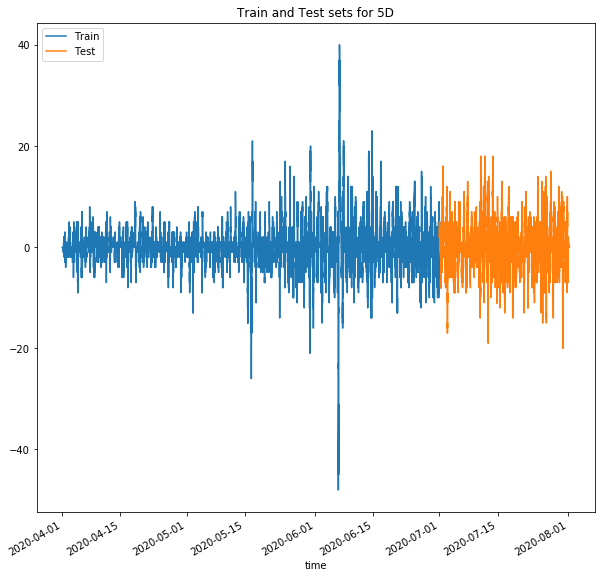

In [74]:
viz.plot_series(three_hour_rolling['5D'],train_end='2020-07-01')

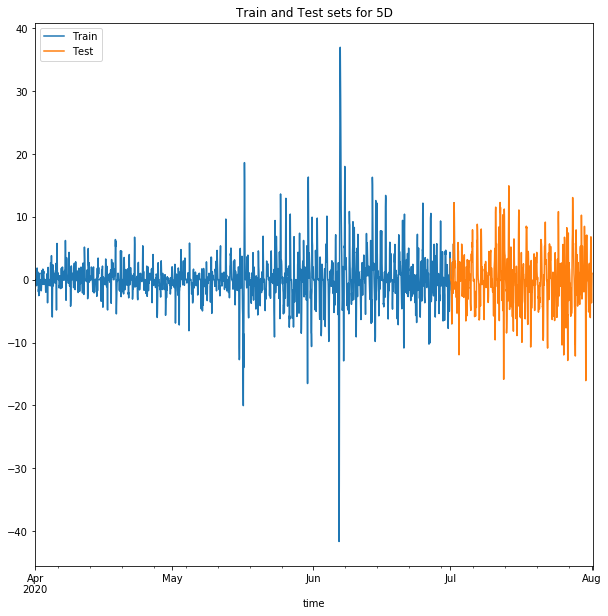

In [78]:
series = three_hour_rolling['5D'].resample('1H').mean()
viz.plot_series(series,train_end='2020-07-01')

In [100]:
series = three_hour_rolling['1A'].resample('1H').mean()

# Leaving aside month of July as a Test Set, this is about 25% of the data
test_start = '2020-07-01 00:00:00'

# Make the train/test splits
train = series[series.index < test_start]
test = series[test_start:]

# Checking output lens add up to len of series (they do)
print(len(series), len(test), len(train))

# model
model = SARIMAX(train, order=(0,1,1), seasonal_order=(0,1,1,24))

2937 753 2184


In [101]:
# Fit Model
result = model.fit()

In [102]:
preds = result.predict(start=train.index[0], end=test.index[-1], dynamic=test_start)

## SARIMAX crushes it in-sample, even catching huge spikes, it does much less well as distance out of sample decreases

- Since our business use case is for fleet rebalancing on an intraday basis rather than predicting out of sample forecast one month out, it seems quite fair to use walk-forward modeling here
- Future improvement: would reaaaaallly like to add a seasonal weekly component with s=168 (i.e. both daily s=24, and weekly s=168)

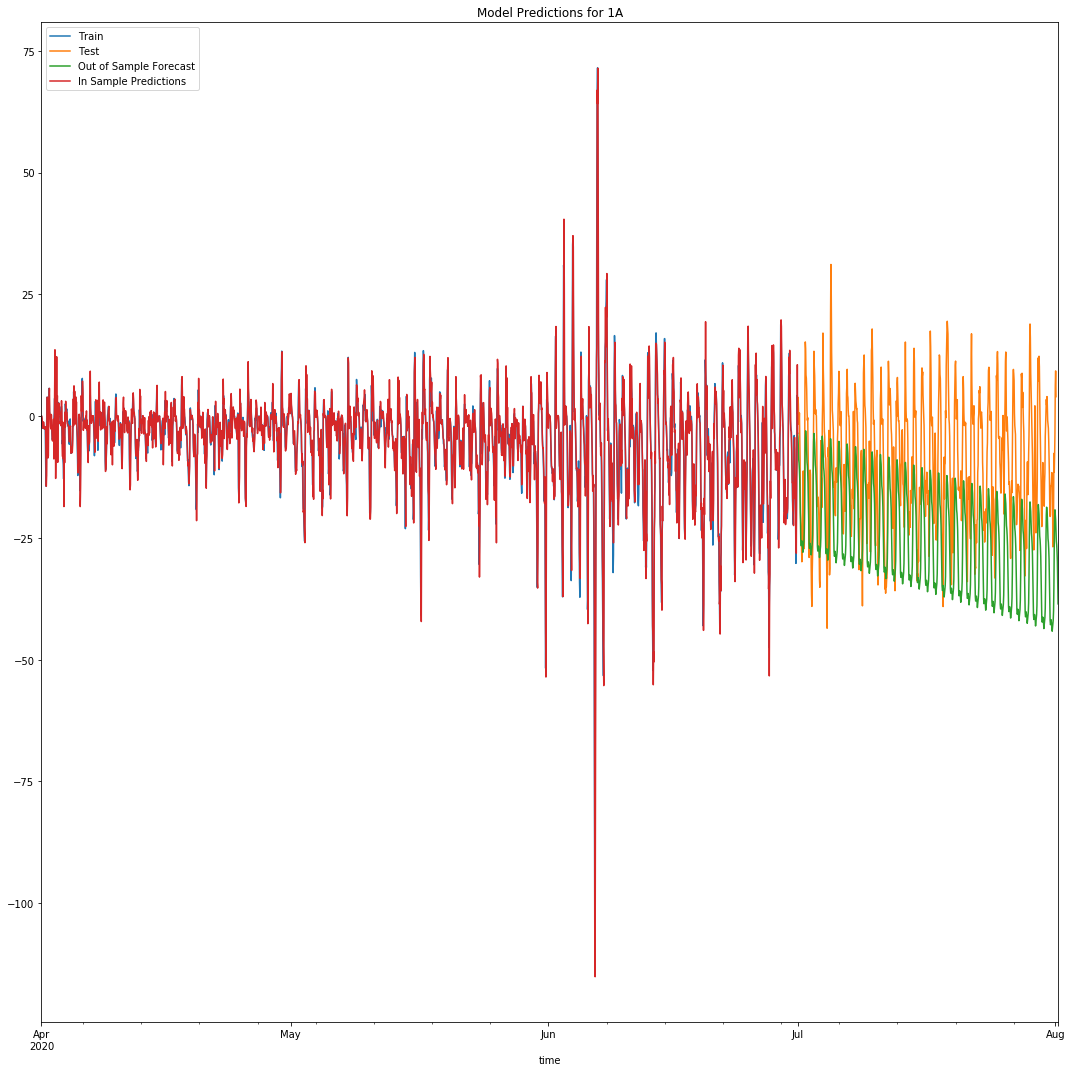

In [110]:
fig, ax = viz.plot_series(series, train_end=test_start, preds=preds, fig_size=(15,15))

In [114]:
ax.set_title('Naive SARIMA model Prediction 1 Month out of Sample for ANC 1A \n config=(0,1,1)(0,1,1,24)')
fig.savefig('../figures/declining_out_of_sample.png')

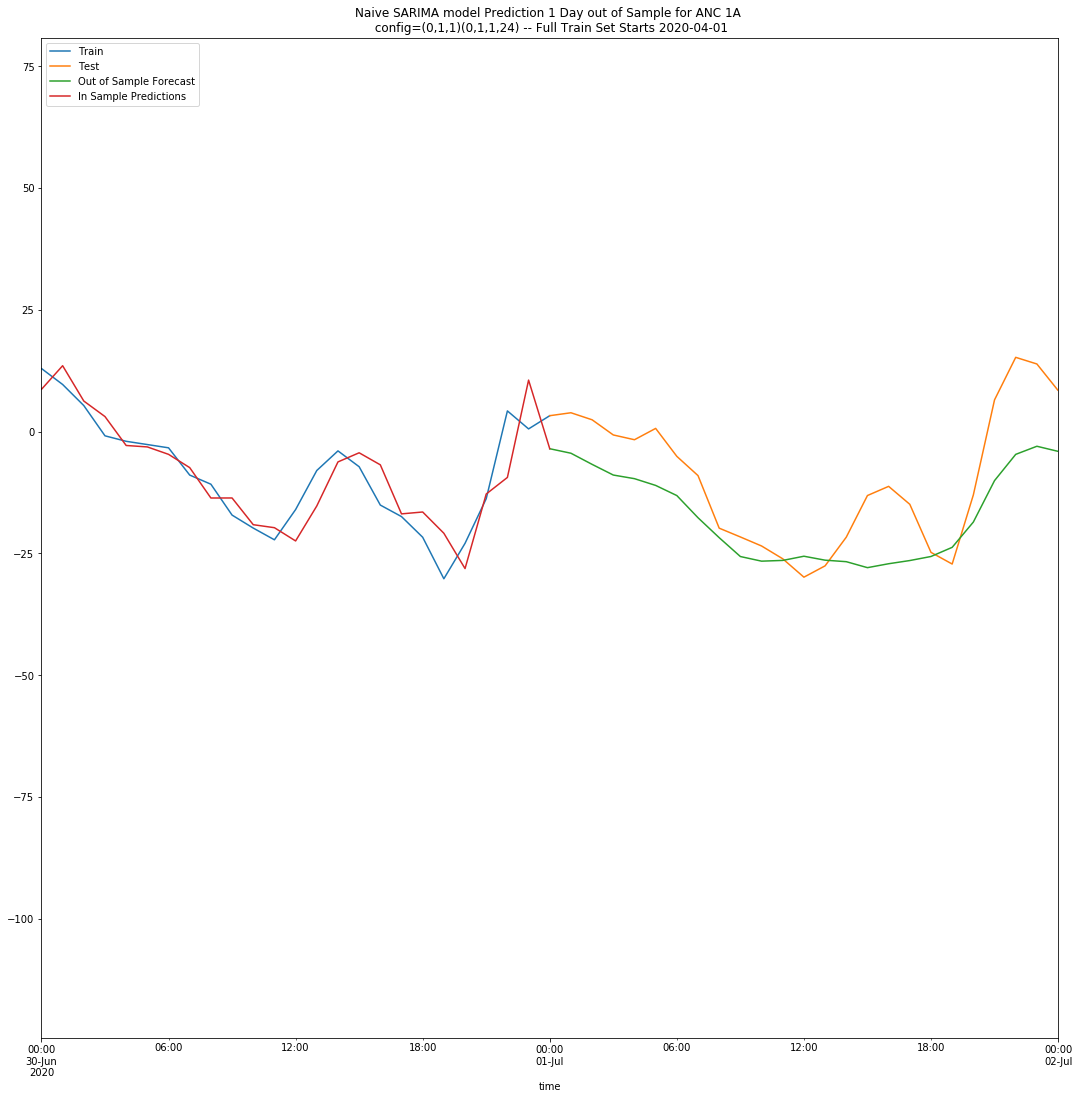

In [120]:
ax.set_xlim(ax.set_xlim([dt.date(2020, 6, 30), dt.date(2020, 7, 2)]))
ax.set_title('Naive SARIMA model Prediction 1 Day out of Sample for ANC 1A \n config=(0,1,1)(0,1,1,24) -- Full Train Set Starts 2020-04-01')
fig.savefig('../figures/one_day_pred_no_walk_forward.png')
fig

In [124]:
summary_daily1A = result.summary()
summary_daily1A

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                 1A   No. Observations:                 2184
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 24)   Log Likelihood               -6303.694
Date:                            Sun, 30 Aug 2020   AIC                          12613.388
Time:                                    12:49:03   BIC                          12630.420
Sample:                                04-01-2020   HQIC                         12619.618
                                     - 06-30-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3188      0.011     29.891      0.000       0.298       0.340
ma.S.L24      -0.9461      0.005   -182.420      0.000      -0.956      -0.936
sigma2        20.2999      0.281     72.319      0.000      19.750      20.850
===================================================================================
Ljung-Box (Q):                      559.89   Jarque-Bera (JB):              8496.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.73   Skew:                             0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Attempting a Weekly Seasonal with s=168

In [125]:
series = three_hour_rolling['1A'].resample('1H').mean()

# Leaving aside month of July as a Test Set, this is about 25% of the data
test_start = '2020-07-01 00:00:00'

# Make the train/test splits
train = series[series.index < test_start]
test = series[test_start:]

# Checking output lens add up to len of series (they do)
print(len(series), len(test), len(train))

# model
model = SARIMAX(train, order=(0,1,1), seasonal_order=(0,1,1,168))

2937 753 2184


In [126]:
result = model.fit()

In [ ]:
preds = result.predict(start=train.index[0], end=test.index[-1], dynamic=test_start)

NameError: name 'result' is not defined

In [ ]:
recent_geo.started_at.value_counts().head(60)

In [ ]:
cleaned_recent[cleaned_recent.started_at > cleaned_recent.ended_at]

In [ ]:
recent_geo[recent_geo.started_at.isin(recent_geo.started_at.value_counts().head(60).index) & (recent_geo.duration_seconds == 1118.0)].start_station_name.value_counts()

In [ ]:
recent_geo[recent_geo.started_at == '2020-07-23 11:24:54']

In [ ]:
historical = pd.concat(raw_dfs[:-4])
historical

In [ ]:

def prop_top(col):
    """Return the proportion of the total observations that the mode observation makes up for a given pandas Series"""
    rounded = round(col, 4)
    count_top = rounded.value_counts().values[0]
    total = len(rounded)
    prop = count_top / total
    return prop

def count_obs(col, name):
    """Return number of instances of name in col"""
    
    count = len(col[col == name])
    return count

stations = list(raw_apr_to_jul_df.start_station_name.value_counts().index)
stations.remove('Motivate Tech Office')
prop_lats = {name: prop_top(raw_apr_to_jul_df[raw_apr_to_jul_df.start_station_name == name].start_lat)\
             for name in stations}

prop_lngs = {name: prop_top(raw_apr_to_jul_df[raw_apr_to_jul_df.start_station_name == name].start_lng)\
             for name in stations}

prop_lats = {k: v for k, v in sorted(prop_lats.items(), key=lambda item: item[1])}
prop_lngs = {k: v for k, v in sorted(prop_lngs.items(), key=lambda item: item[1])}


# station_counts = {station: count_obs(raw_apr_to_jul_df['start_station_name'], station) for station in stations}
# station_counts

## In General It Seems very reasonable to impute start_lat/lng for each station from top value_count, there are 16 stations for which either lat or lng impute strategy is less than 90% accurate
- Saving these in a list, visualize to look for pattern or outliers

In [ ]:
inaccurate_keys = []
for key in prop_lats.keys():
    if (prop_lats[key] < 0.9) | (prop_lngs[key] < 0.9):
        print(f'{key}: {prop_lats[key]}, {prop_lngs[key]}')
        inaccurate_keys.append(key)

inaccurate_keys
    

In [ ]:
# raw_july = pd.read_csv(csv_paths[-1])

# raw_dockless = raw_july[raw_july.rideable_type == 'electric_bike']
# pd.to_pickle(raw_dockless, '../data/wip/raw_dockless.pkl')
# pd.to_pickle(gdf, '../data/wip/gdf_anc.pkl')

gdf = get_data.anc_gdf()

def plot_trips(df, axe):
    gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', ax=axe)
    sns.scatterplot(x='start_lng', y='start_lat', data=df, ax=axe)

## No Readily Discernable Pattern Geographically to the no end lat/lng trips

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

plot_trips(raw_apr_to_jul_df[raw_apr_to_jul_df.end_lat.isna()], axe=ax)

In [ ]:
fig, axes = plt.subplots(8,2, figsize=(10, 30))
axes = axes.ravel()

for i, key in enumerate(inaccurate_keys):
    df = raw_apr_to_jul_df.loc[
        raw_apr_to_jul_df['start_station_name'] == key, ['start_lng', 'start_lat']]
    sns.scatterplot(x='start_lng', y='start_lat', data=df, ax=axes[i])
    axes[i].set_title(key)

fig.tight_layout()
plt.show()

In [ ]:
pd.to_pickle(raw_apr_to_jul_df, '../data/wip/raw_apr_to_jul_df.pkl')

In [ ]:
df = raw_apr_to_jul_df.loc[
    raw_apr_to_jul_df['start_station_name'] == key, ['start_lng', 'start_lat']

## Running Notes
- Feature engineer churn metric for each station? Then predict continuous outcome?